# DURC

Classify URLs

# Constants

Here, you can alter the dataset, maximum number of samples to use, etc.

In [ ]:
DMOZ, ILP, PHISHING = 'dmoz', 'ilp', 'phishing'

DATASET = DMOZ  # one of the above datsets
MAX_NUM_SAMPLES = 100_000

TEST_PROP = 0.2
VAL_PROP = 0.2
EPOCHS = 20

SEED = 42

## Setup


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
command = f'git clone --depth 1 https://github.com/shmulvad/nlp-project.git'
!{command}

%cd nlp-project/src

Cloning into 'nlp-project'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 58 (delta 6), reused 33 (delta 3), pack-reused 0
Unpacking objects: 100% (58/58), done.
/content/nlp-project/src


In [ ]:
!pip install gdown

# DMOZ, ILP and original phishing dataset - datasets.pkl
!gdown --id 1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_

print('\n')
!ls

Downloading...
From: https://drive.google.com/uc?id=1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_
To: /content/nlp-project/src/datasets.pkl
99.4MB [00:02, 41.1MB/s]


 baselines		    demo.ipynb	       self_trained_embeddings.py
'Colab Notebooks'	    featurizer.py      tests
 create_fasttext_embed.py   pickle_data.py     url_tokenizer.py
 data			    read_data.py       util.py
 datasets.pkl		    requirements.txt   word_embed


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -r requirements.txt

     |████████████████████████████████| 3.4MB 17.3MB/s 
     |████████████████████████████████| 1.1MB 19.7MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 1.2MB 57.6MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 645kB 54.0MB/s 
     |████████████████████████████████| 174kB 59.4MB/s 
     |████████████████████████████████| 358kB 57.7MB/s 
     |████████████████████████████████| 37.6MB 81kB/s 
     |████████████████████████████████| 706kB 49.5MB/s 
     |████████████████████████████████| 542kB 18.0MB/s 
     |████████████████████████████████| 23.9MB 1.5MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=14eae4c476b9e57a9f9de1982b95a54c6123fbf84edf0121e8eea17f73cb1ae5
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
  Found existing installation: gensim

In [ ]:
import os
import shutil
import random
import pickle

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pprint import pprint
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import gensim
from gensim.models.keyedvectors import FastTextKeyedVectors

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
tf.get_logger().setLevel('ERROR')
np.random.seed(SEED)

from read_data import read_all_datasets
from url_tokenizer import url_tokenizer, flatten_url_data
from featurizer import UrlFeaturizer, GLOVE, CONCEPTNET, SAMPLE

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
with open('datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)

assert DATASET in datasets, \
    f'You tried to load {DATASET} but only {list(datasets.keys())} available.'

dataset = datasets[DATASET]
dataset

,idx,url,label
946066,946067,http://www.thepipe.info,Recreation
1322925,1322926,http://childlifeline.org,Society
1538731,1538732,http://www.fchd.info/fleett.htm,Sports
529412,529413,http://www.ee.umn.edu/users/kieffer/,Computers
639891,639892,http://www.ftprush.com,Computers
...,...,...,...
1467240,1467241,http://www.usatoday.com/sports/college/mensbas...,Sports
483946,483947,http://www.appraisal.co.nz/,Business
900141,900142,http://www.wild-about-hunting.com/,Recreation
320948,320949,http://www.searchlites.com/,Business


In [ ]:
# Download respectively model and ngrams
if DATASET == DMOZ:
  !gdown --id 1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
  !gdown --id 15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
elif DATASET == ILP:
  !gdown --id 1_QafULaXKmq0H0fwY3dkR-WOKwsyUkHS
  !gdown --id 1kn4EbllSLdAX-8Ca5db6_BewLugCAWp5
else:  # Phishing
  !gdown --id 1JEsUG4eGqbIItBH468xph-AsS3iQ5Fif
  !gdown --id 10p0XPRsuTsXblQNNlUricEmd8if0B2P6

embedding = FastTextKeyedVectors.load(f'embed-{DATASET}.model')

Downloading...
From: https://drive.google.com/uc?id=1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
To: /content/nlp-project/src/embed-dmoz.model
23.0MB [00:00, 44.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
To: /content/nlp-project/src/embed-dmoz.model.vectors_ngrams.npy
800MB [00:13, 59.8MB/s]


In [ ]:
feat = UrlFeaturizer(embedding=embedding)

Creating the average vector of all the word vectors...
Created FastText UrlFeaturizer in 0.0 s


In [ ]:
feat.featurize('http://sample.com')

(array([ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 10,  0,  0,  0,
         0,  0,  0]),
 array([[ 0.77026248,  0.46089965,  1.26344168, ...,  0.66362536,
          0.34823999, -0.18292134],
        [-0.20754965,  0.57599968, -0.14255302, ..., -0.22249998,
          0.54267246,  1.67496264],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]))

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
test_url = dataset['url'].iloc[0]

vec, mat = feat.featurize(test_url)

url_data = url_tokenizer(test_url)
url_flat_lst = flatten_url_data(url_data)
url_flat = ' '.join(url_flat_lst)

text_preprocessed = bert_preprocess_model([url_flat])

print(f'URL        : {test_url}')
print(f'URL flat   : {url_flat}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

URL        : http://www.thepipe.info
URL flat   : http www the pipe info
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  8299  7479  1996  8667 18558   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.00361865  0.9974153  -0.99529904 -0.22447802 -0.9434775   0.62250054
  0.25889897 -0.13676828 -0.986421   -0.35827413 -0.06381476 -0.4071286 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.0066224   0.33793563  0.1651968  ...  0.3993891   0.17727925
   0.37627977]
 [-0.23351853  0.39609352  0.31572127 ... -0.54058766  0.24096048
   0.7564982 ]
 [ 0.4214562   0.06643073  0.7803554  ... -0.19821711 -0.3319404
   0.45022112]
 ...
 [ 0.08875236  0.729173   -0.45449984 ...  0.34969813  0.17700747
   0.05872137]
 [ 0.46900678  0.41907883  0.41059265 ...  0.08870018 -0.00837477
   0.24160038]
 [ 0.35212272  0.5305757   0.36495954 ... -0.08279523  0.04219694
   0.43598697]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Restricting Dataset

Limit dataset if DMOZ and make the labels categorical


In [ ]:
if DATASET == 'dmoz':
    dataset = dataset.sample(MAX_NUM_SAMPLES)

dataset

,idx,url,label
1478154,1478155,http://www.physics.ubc.ca/~rcoope,Sports
1440788,1440789,http://www.divinity.cam.ac.uk/carts/gender.html,Society
557247,557248,http://deepblog.com/,Computers
956912,956913,http://www.tiaa.edu.ge/,Reference
333932,333933,http://www.firstediting.com,Business
...,...,...,...
149559,149560,http://www.rollingstone.com/artists/janisian,Arts
85056,85057,http://andybragen.com,Arts
175104,175105,http://www.wqxr.com/cgi-bin/iowa/cla/learning/...,Arts
1214881,1214882,http://www.janhart.com/,Shopping


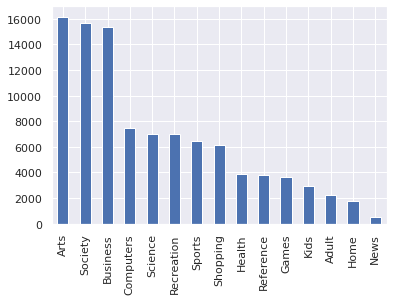

In [ ]:
dataset['label'].value_counts().plot(kind='bar')

In [ ]:
labels = np.array(dataset.label.unique())
label_to_num = {label: i for i, label in enumerate(labels)}
num_classes = len(label_to_num)

print('Num classes:', num_classes)
pprint(label_to_num)

Num classes: 15
{'Adult': 9,
 'Arts': 7,
 'Business': 4,
 'Computers': 2,
 'Games': 6,
 'Health': 10,
 'Home': 8,
 'Kids': 13,
 'News': 14,
 'Recreation': 5,
 'Reference': 3,
 'Science': 12,
 'Shopping': 11,
 'Society': 1,
 'Sports': 0}


# Define Model

In this section, we define the model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, LSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Input

In [ ]:
def build_classifier_model_custom():
    input_text = Input(shape=(), dtype=tf.string, name='Flat_URL_Text')
    input_embed = Input(shape=(feat.N, feat.embedding_dim), name='Static_FastText_Embeddings')
    input_feat_vec = Input(shape=(feat.hand_picked_feat_len,), name='Feature_Vector')

    # BERT
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_Preprocesser')
    encoder_inputs = preprocessing_layer(input_text)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    bert_out = outputs['pooled_output']
    bert_dropout = Dropout(0.2)(bert_out)
    bert_flattened = Flatten()(bert_dropout)
    model1 = Model(inputs=input_text, outputs=bert_flattened)

    # LSTM for static embeddings
    y = Bidirectional(LSTM(32, return_sequences=True, activation='relu'))(input_embed)
    y = Dropout(0.2)(y)
    y = Bidirectional(LSTM(64, return_sequences=True, activation='relu'))(y)
    y = Dropout(0.2)(y)
    y = Dense(32, activation='relu', name='LSTM_Features')(y)
    y = Flatten()(y)
    model2 = Model(inputs=input_embed, outputs=y)

    # y = Conv1D(32, 3, activation='relu', name='ConvWordMat')(input_embed)
    # y = Dropout(0.2)(y)
    # y = Conv1D(64, 3, activation='relu')(y)
    # y = Dropout(0.2)(y)
    # y = Dense(32, activation='relu')(y)
    # y = Flatten()(y)
    # model2 = Model(inputs=input_embed, outputs=y)

    # Dense layer for feature vector
    d = Dense(8, activation='relu')(input_feat_vec)
    model3 = Model(inputs=input_feat_vec, outputs=d)

    # Combining them
    combined = concatenate([model1.output, model2.output, model3.output], name='Concat')
    #combined = tf.keras.layers.Dropout(0.1)(combined)
    z = Attention(name='Self_Attention')([combined, combined])
    z = Dense(num_classes, name='classifier')(z)
    return Model(inputs=[model1.input, model2.input, model3.input], outputs=z)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model_custom()

In [ ]:
const_inp = [tf.constant([url_flat]), tf.constant([mat]), tf.constant([vec])]
bert_raw_result = classifier_model(const_inp)
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.6031452  0.6990198  0.5162589  0.7090281  0.48683736 0.26841968
  0.7017791  0.62888986 0.8045864  0.3457965  0.3943318  0.5894187
  0.26991728 0.7766015  0.6244447 ]], shape=(1, 15), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

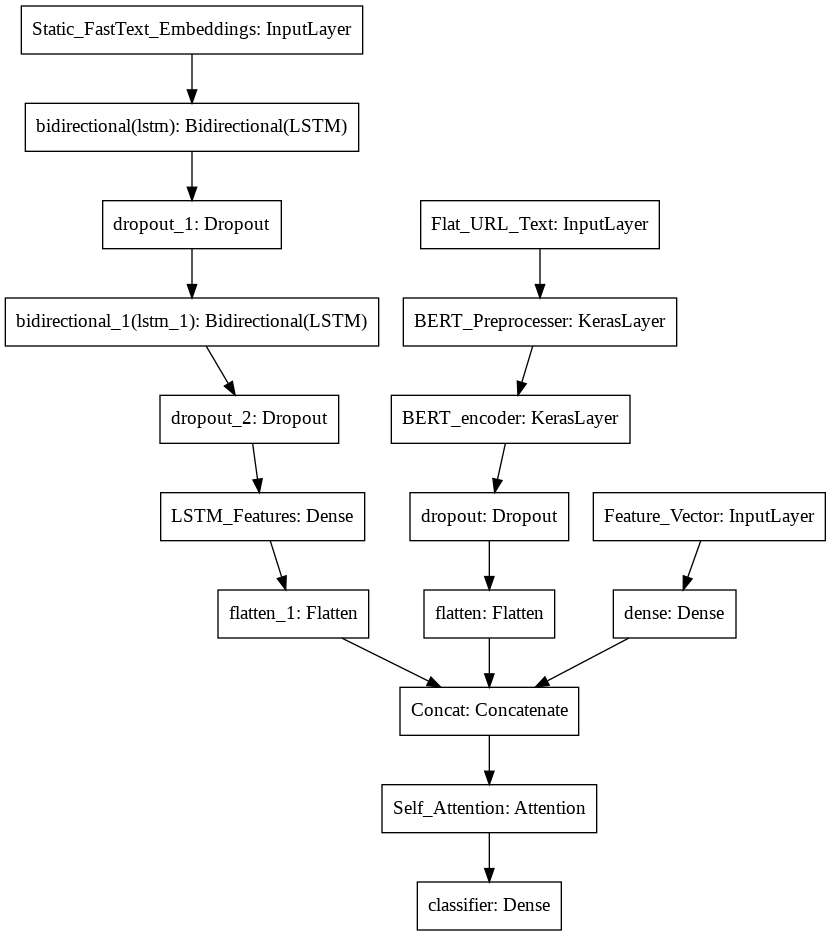

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

We now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and full classifier.

### Loss function

Since this is a multi-class classification problem and the model outputs a probability (a single-unit layer), we'll use `SparseCategoricalCrossentropy` and `SparseCategoricalAccuracy`.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

### Data Columns

Here, we create a column of flattened URLs in the dataset and a column of the labels sparse.

In [ ]:
def clean_url(url: str) -> str:
    try:
        url_data = url_tokenizer(url)
        url_flat_lst = flatten_url_data(url_data)
        url_flat = ' '.join(url_flat_lst)
        return url_flat
    except Exception as e:
        print('Error:', e)
        return ''

In [ ]:
dataset['urlClean'] = dataset['url'].apply(clean_url)
dataset['sparseLabel'] = dataset['label'].map(label_to_num)

dataset

,idx,url,label,urlClean,sparseLabel
1478154,1478155,http://www.physics.ubc.ca/~rcoope,Sports,http www physics ubc ca r coop e,0
1440788,1440789,http://www.divinity.cam.ac.uk/carts/gender.html,Society,http www divinity cam ac uk carts gender html,1
557247,557248,http://deepblog.com/,Computers,http deep blog com,2
956912,956913,http://www.tiaa.edu.ge/,Reference,http www tiaa edu ge,3
333932,333933,http://www.firstediting.com,Business,http www first editing com,4
...,...,...,...,...,...
149559,149560,http://www.rollingstone.com/artists/janisian,Arts,http www rolling stone com artists janis ian,7
85056,85057,http://andybragen.com,Arts,http andy brage n com,7
175104,175105,http://www.wqxr.com/cgi-bin/iowa/cla/learning/...,Arts,http www wqxr com cgi bin iowa cla learning gr...,7
1214881,1214882,http://www.janhart.com/,Shopping,http www jan hart com,11


We split the data. We also convert the data to the desired input format for multiple-input models.

In [ ]:
X, y = dataset[['urlClean', 'url']], dataset['sparseLabel'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PROP, random_state=SEED)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80000, 2), (80000,), (20000, 2), (20000,))

In [ ]:
def to_multi_input(df):
    urls = df['url'].to_numpy()
    vecs, mats = map(np.array, zip(*feat.featurize(urls)))
    return [df['urlClean'].to_numpy().astype(str), mats, vecs]

In [ ]:
X_train_pre = to_multi_input(X_train)

print([x.shape for x in X_train_pre])

[(80000,), (80000, 15, 100), (80000, 20)]


### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor='val_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True, mode='max',
                             save_weights_only=True)
early = EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', patience=4)

init_lr = 5e-5
optimizer_type='adamw'
num_train_steps = 3125
num_warmup_steps = 312

optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type=optimizer_type
)

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
%%time

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=X_train_pre,
    y=y_train,
    validation_split=VAL_PROP,
    epochs=EPOCHS,
    callbacks=[checkpoint, early]
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Epoch 1/20
2000/2000 [==============================] - 367s 180ms/step - loss: 2.1883 - sparse_categorical_accuracy: 0.3181 - val_loss: 1.6766 - val_sparse_categorical_accuracy: 0.4889

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.48894, saving model to /tmp/checkpoint
Epoch 2/20
2000/2000 [==============================] - 358s 179ms/step - loss: 1.5579 - sparse_categorical_accuracy: 0.5132 - val_loss: 1.6190 - val_sparse_categorical_accuracy: 0.5031

Epoch 00002: val_sparse_categorical_accuracy improved from 0.48894 to 0.50313, saving model to /tmp/checkpoint
Epoch 3/20
2000/2000 [==============================] - 358s 179ms/step - loss: 1.5196 - sparse_categorical_accuracy: 0.5263 - val_loss: 1.6190 - val_sparse_categorical_accuracy: 0.5031

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.50313
Epoch 4/20
2000/2000 [==============================] 

In [ ]:
classifier_model.load_weights(checkpoint_filepath)

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
X_test_pre = to_multi_input(X_test)

print([x.shape for x in X_test_pre])

[(20000,), (20000, 15, 100), (20000, 20)]


In [ ]:
y_pred1 = classifier_model.predict(X_test_pre)
y_pred = np.argmax(y_pred1, axis=1)

report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

              precision    recall  f1-score   support

      Sports     0.6806    0.5767    0.6244      1271
     Society     0.5324    0.6028    0.5654      3165
   Computers     0.4531    0.3501    0.3950      1491
   Reference     0.4188    0.4611    0.4390       733
    Business     0.4649    0.6967    0.5577      3040
  Recreation     0.4547    0.3306    0.3829      1352
       Games     0.6721    0.4639    0.5490       707
        Arts     0.5183    0.6468    0.5755      3216
        Home     0.7202    0.3877    0.4955       368
       Adult     0.6370    0.4345    0.5166       412
      Health     0.5991    0.3392    0.4249       799
    Shopping     0.4112    0.4254    0.4070      1300
     Science     0.4824    0.4173    0.4675      1445
        Kids     0.4083    0.1164    0.2411       593
        News     0.8282    0.1133    0.2213       108

    accuracy                         0.5373     20000
   macro avg     0.5714    0.4535    0.5229     20000
weighted avg     0.5836   